# Target
- Tweaking model to enhance accuracy





# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))# The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                      
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                      
                                      
                                  
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [116]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),   
            nn.ReLU()
         
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
     #       nn.Dropout(0.0)
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=24, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(24), 
            nn.ReLU(),
            nn.Dropout(0.03)
         
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=24, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.Dropout(0.03)
       #     nn.Dropout(0.05)
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
            
         
        ) # output_size = 7

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=7)
        ) # output_size = 1



    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [175]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
            Conv2d-4           [-1, 16, 24, 24]           1,152
       BatchNorm2d-5           [-1, 16, 24, 24]              32
              ReLU-6           [-1, 16, 24, 24]               0
            Conv2d-7           [-1, 24, 22, 22]           3,456
       BatchNorm2d-8           [-1, 24, 22, 22]              48
              ReLU-9           [-1, 24, 22, 22]               0
          Dropout-10           [-1, 24, 22, 22]               0
        MaxPool2d-11           [-1, 24, 11, 11]               0
           Conv2d-12            [-1, 8, 11, 11]             192
             ReLU-13            [-1, 8, 11, 11]               0
           Conv2d-14             [

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [180]:
#V1 Train: 97.85, test 97.82
#V2 with Batch Normalization : Train= 99.17 , Test = (98.96%)
#V2 with Batch Normalization and dropout : Train= 98.54 , Test = 98.26%
#V3 Image augmentation & degrees and drop out reduced to 5% Train= 98.53: , Test= 99.00%
from torch.optim.lr_scheduler import StepLR


model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.08, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
EPOCHS = 15



for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader,optimizer  , epoch)
    scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.06034499779343605 Batch_id=468 Accuracy=91.38: 100%|██████████| 469/469 [00:11<00:00, 39.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1437, Accuracy: 9562/10000 (95.62%)

EPOCH: 1


Loss=0.09637129306793213 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:12<00:00, 38.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0712, Accuracy: 9768/10000 (97.68%)

EPOCH: 2


Loss=0.06821875274181366 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:11<00:00, 39.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0736, Accuracy: 9768/10000 (97.68%)

EPOCH: 3


Loss=0.07043483853340149 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:11<00:00, 39.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0390, Accuracy: 9879/10000 (98.79%)

EPOCH: 4


Loss=0.025659412145614624 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:12<00:00, 38.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0402, Accuracy: 9888/10000 (98.88%)

EPOCH: 5


Loss=0.02284420095384121 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:12<00:00, 39.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0327, Accuracy: 9902/10000 (99.02%)

EPOCH: 6


Loss=0.043099697679281235 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:12<00:00, 39.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9937/10000 (99.37%)

EPOCH: 7


Loss=0.08443301171064377 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:12<00:00, 38.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9939/10000 (99.39%)

EPOCH: 8


Loss=0.02512727677822113 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:12<00:00, 38.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9942/10000 (99.42%)

EPOCH: 9


Loss=0.002026081085205078 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:11<00:00, 39.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9935/10000 (99.35%)

EPOCH: 10


Loss=0.0034510295372456312 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:11<00:00, 39.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9938/10000 (99.38%)

EPOCH: 11


Loss=0.05268149450421333 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:12<00:00, 38.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9939/10000 (99.39%)

EPOCH: 12


Loss=0.025380665436387062 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:11<00:00, 39.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9941/10000 (99.41%)

EPOCH: 13


Loss=0.006091515067964792 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:12<00:00, 39.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9938/10000 (99.38%)

EPOCH: 14


Loss=0.022154157981276512 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:11<00:00, 39.94it/s]



Test set: Average loss: 0.0193, Accuracy: 9944/10000 (99.44%)



Text(0.5, 1.0, 'Test Accuracy')

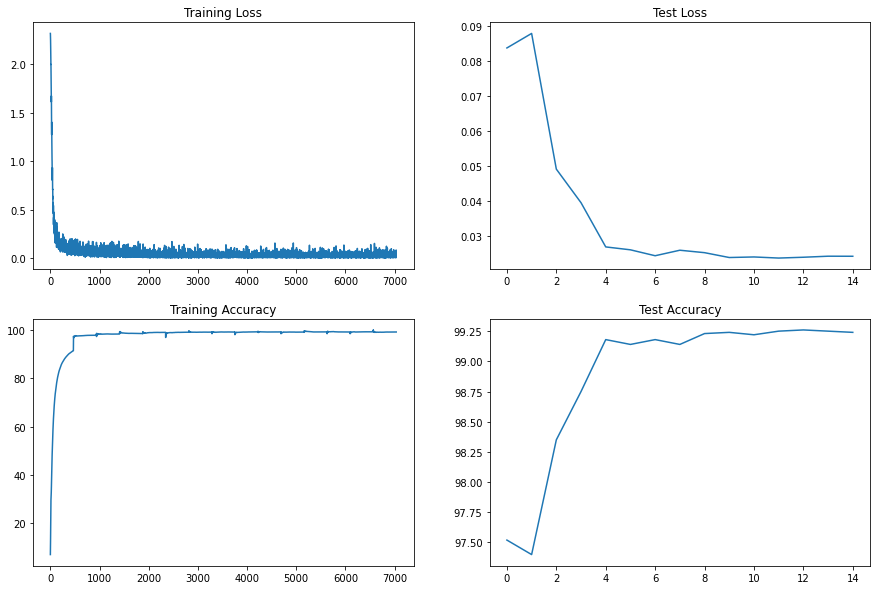

In [178]:
# with LR train:97.73 test 98.29%

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")